In [115]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pylab as plt
from tqdm.auto import tqdm

%matplotlib inline
sns.set(rc={'figure.figsize':(15,9)}, style='whitegrid')

In [2]:
%pip install vk_api

  Created wheel for vk-api: filename=vk_api-11.9.1-cp36-none-any.whl size=44097 sha256=437ed5ac3d77813a409dbdce55bd9906beacc9a70db908ac53c15ecddb3c088c
  Stored in directory: /root/.cache/pip/wheels/fc/43/59/8fba75529a5b85d5ff706007d699ab18bb90b7b54e074797c5
Successfully built vk-api


In [3]:
import vk_api

## Задача
Проанализировать сообщества пользователя: 
1. Найти сообщества, с наибольшим общим количеством друзей; 
2. Найти самое популярное сообщество среди друзей.




---

---





## 1.

In [75]:

def auth_handler():
    """ При двухфакторной аутентификации вызывается эта функция.
    """
    # Код двухфакторной аутентификации
    key = input("Enter authentication code: ")
    # Если: True - сохранить, False - не сохранять.
    remember_device = True
    return key, remember_device

def vk_session_init(user_login, user_password):
  vk_session = vk_api.VkApi(
    user_login, user_password,
    auth_handler=auth_handler # функция для обработки двухфакторной аутентификации
  )
  return vk_session

In [76]:
user_login = ''
user_password = ''
vk_session = vk_session_init(user_login, user_password)
try:
    vk_session.auth()
except vk_api.AuthError as error_msg:
    print(error_msg)
vk = vk_session.get_api()

Enter authentication code: 746261


Получим список групп пользователя, список друзей и список групп друзей, а в конце объединим эти два списка.

In [80]:
user_id = vk.users.get()[0]['id'] #получаем id авторизованного пользователя
#user_id = 55420799
user_id

55420799

In [81]:
user_groups = vk.groups.get(user_id=user_id, extended=1)
user_groups_df = pd.DataFrame(user_groups['items'])
user_groups_df['user_id'] = user_id
user_groups_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,admin_level,user_id
0,125004421,Настоящий Лентач,true_lentach,0,page,0,1,0,https://sun9-67.userapi.com/s/v1/ig2/35DtoNB6E...,https://sun9-67.userapi.com/s/v1/ig2/6ajcAns_T...,https://sun9-67.userapi.com/s/v1/ig2/JjkFmbalT...,NaN,55420799
1,33880573,THE DUMP,dumpers,0,page,0,1,0,https://sun9-43.userapi.com/s/v1/if1/099Fhum7g...,https://sun9-43.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun9-43.userapi.com/s/v1/if1/LKWp0K0Sv...,NaN,55420799
2,169934613,KARPOV.COURSES,karpovcourses,0,page,0,1,0,https://sun9-23.userapi.com/s/v1/ig2/C1Ke892N5...,https://sun9-23.userapi.com/s/v1/ig2/wrGIlPa-_...,https://sun9-23.userapi.com/s/v1/ig2/cAbZcIBLF...,NaN,55420799
3,20629724,Хабр,habr,0,page,0,1,0,https://sun9-44.userapi.com/s/v1/ig1/cvgInBNS_...,https://sun9-44.userapi.com/s/v1/ig1/eMUYlx1UV...,https://sun9-44.userapi.com/s/v1/ig1/xiDx2spXM...,NaN,55420799
4,31480508,Пикабу,pikabu,0,page,0,1,0,https://sun9-76.userapi.com/s/v1/if1/v0HEGsil2...,https://sun9-76.userapi.com/s/v1/if1/SKPh1hvjc...,https://sun9-76.userapi.com/s/v1/if1/qLMUnORnQ...,NaN,55420799


In [82]:
user_groups_df.shape

(243, 13)

In [83]:
user_groups_df.to_csv('user_groups_df.csv')

In [86]:
user_friends_list = vk.friends.get(user_id=user_id)['items']

In [6]:
friends_groups_df = pd.read_csv('friends_groups_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
friends_groups_df = pd.DataFrame()

for friend in user_friends_list:
  try:
    friend_groups_df = pd.DataFrame(vk.groups.get(user_id=friend, extended=1, v=5.126)['items'])
    friend_groups_df['user_id'] = friend
    friends_groups_df = pd.concat([friends_groups_df, friend_groups_df], axis=0)
  except vk_api.exceptions.VkApiError:
    print(f'ApiError по пользователю {friend}')
    continue

In [ ]:
friends_groups_df.to_csv('friends_groups_df.csv') #опционально

In [6]:
friends_groups_df.shape

(12910, 14)

In [7]:
friends_groups_df.head()

,Unnamed: 0,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_id,deactivated
0,0,92307020.0,"Тамара, какого хрена?",odonata_live,0.0,page,0.0,0.0,0.0,https://sun1-22.userapi.com/impf/c836734/v8367...,https://sun1-22.userapi.com/impf/c836734/v8367...,https://sun1-22.userapi.com/impf/c836734/v8367...,56840,NaN
1,1,194622716.0,Linxdatacenter,linxdc,0.0,page,0.0,1.0,0.0,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,56840,NaN
2,2,68696990.0,Удивительная Япония,paradoks_japan,0.0,page,0.0,0.0,0.0,https://sun1-29.userapi.com/impf/c624524/v6245...,https://sun1-29.userapi.com/impf/c624524/v6245...,https://sun1-29.userapi.com/impf/c624524/v6245...,56840,NaN
3,3,60394841.0,Неизвестная Россия,unknown_russia,0.0,page,0.0,0.0,0.0,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,https://sun1-27.userapi.com/impg/MNQx6Po5ktv8y...,56840,NaN
4,4,53895074.0,Питертранспорт | Изменения маршрутов,pitertransport_routes,0.0,page,0.0,0.0,0.0,https://sun1-90.userapi.com/impf/c638121/v6381...,https://sun1-90.userapi.com/impf/c638121/v6381...,https://sun1-90.userapi.com/impf/c638121/v6381...,56840,NaN


In [8]:
friends_groups_df = friends_groups_df[friends_groups_df.deactivated.isna()] # отбираем записи только активных пользователей
friends_groups_df.shape

(12772, 14)

In [7]:
merged_df = pd.read_csv('merged_df.csv') #на случай, если данные уже загружены, тогда пропускаем след. ячейку

In [ ]:
merged_df = pd.concat([friends_groups_df, user_groups_df], axis=0)
merged_df.id = merged_df.id.astype('int')

In [ ]:
merged_df.to_csv('merged_df.csv') #опционально

In [9]:
merged_df.shape

(13151, 16)

Проанализируем самые популярные группы

In [60]:
freinds_groups_freq = friends_groups_df.groupby(['id', 'name'], as_index=False)['type']\
         .count()\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
freinds_groups_freq

,id,name,count
1569,31480508.0,Пикабу,24
1356,29534144.0,Лентач,21
4144,63731512.0,Vandrouki | Путешествия почти бесплатно (RU),21
2073,36338110.0,KudaGo: Санкт-Петербург,20
1113,26762265.0,Томские.ру,16
...,...,...,...
772,22882465.0,ЛАПУШКА детский развивающий центр в РЫБАЦКОМ,1
4193,64701405.0,The Best Music,1
4192,64696640.0,Дата-центр XELENT,1
4191,64673764.0,PARALAM shop,1


In [62]:
commons_groups_freq = merged_df[merged_df.id.isin(user_groups_df.id)].groupby(['id', 'name'], as_index=False)\
         .agg({'type':'count'})\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
commons_groups_freq

,id,name,count
70,31480508,Пикабу,25
130,63731512,Vandrouki | Путешествия почти бесплатно (RU),22
61,29534144,Лентач,22
43,24098496,E.squirе,14
102,41437811,МХК,14
...,...,...,...
96,39369678,Как же это было ￤60-е годы￤,1
93,37624431,Новости часа,1
88,36374634,it's all indie,1
85,35285306,Nature|Природа,1


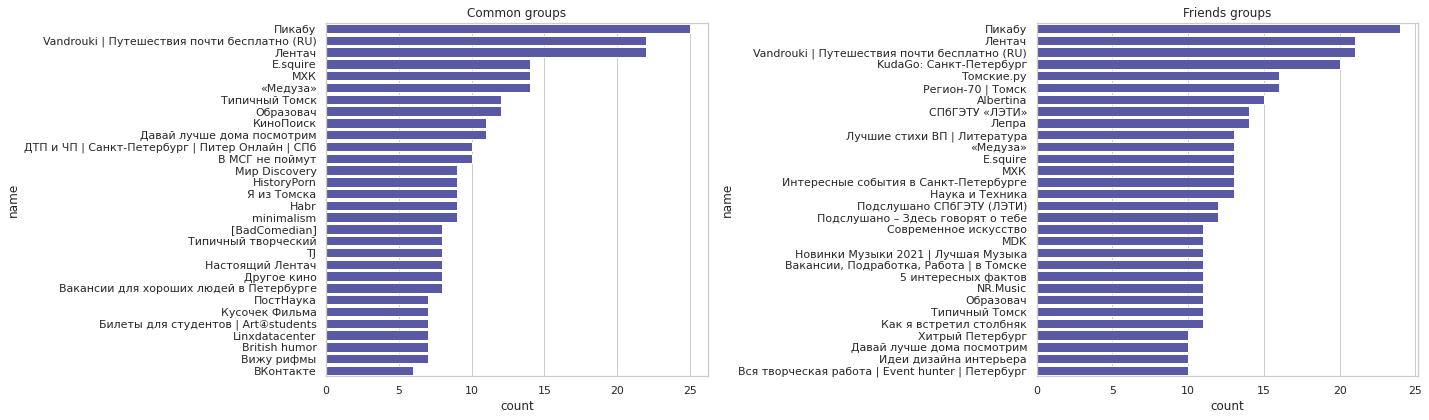

In [71]:
f = plt.figure(figsize=(20, 6))
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
sns.barplot(x=commons_groups_freq['count'][:30], y=commons_groups_freq['name'][:30], saturation=.3, color='blue')
ax.set_title('Common groups')

ax = f.add_subplot(gs[0, 1])
sns.barplot(x=freinds_groups_freq['count'][:30], y=freinds_groups_freq['name'][:30], saturation=.3, color='blue')
ax.set_title('Friends groups')
f.tight_layout()

Выше представлена графики распределения количества общих групп пользователя и его друзей и отдельно по группам друзей. Можно сразу отметить полное совпадение Топ-3 групп - все мы любим смешные картинки, интересные истории и желание недорого путешествовать.

Также сразу бросается в глаза, что большое количество общих друзей в группах относятся к двух городам - Томск и Санкт-Петербург, видимо, пользователь тесно связан с этими городами. 

In [40]:
user_groups_df = merged_df.query("user_id == 55420799")

In [41]:
user_groups_df.head()

,Unnamed: 0,Unnamed: 0.1,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_id,deactivated,admin_level
12910,0,NaN,33880573,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun1-24.userapi.com/s/v1/if1/099Fhum7g...,https://sun1-24.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun1-24.userapi.com/s/v1/if1/LKWp0K0Sv...,55420799,NaN,NaN
12911,1,NaN,31480508,Пикабу,pikabu,0.0,page,0.0,1.0,0.0,https://sun1-16.userapi.com/s/v1/if1/v0HEGsil2...,https://sun1-16.userapi.com/s/v1/if1/SKPh1hvjc...,https://sun1-16.userapi.com/s/v1/if1/qLMUnORnQ...,55420799,NaN,NaN
12912,2,NaN,169934613,KARPOV.COURSES,karpovcourses,0.0,page,0.0,1.0,0.0,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,55420799,NaN,NaN
12913,3,NaN,125004421,Настоящий Лентач,true_lentach,0.0,page,0.0,1.0,0.0,https://sun1-17.userapi.com/s/v1/ig2/35DtoNB6E...,https://sun1-17.userapi.com/s/v1/ig2/6ajcAns_T...,https://sun1-17.userapi.com/s/v1/ig2/JjkFmbalT...,55420799,NaN,NaN
12914,4,NaN,40232010,Что-то новое,dfzwe4,0.0,page,0.0,1.0,0.0,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,55420799,NaN,NaN


In [42]:
user_groups_df.shape

(241, 16)

In [54]:
merged_df[merged_df.id.isin(user_groups_df.id)].groupby(['id', 'name'], as_index=False)['type']\
         .count()\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})

,id,name,count
70,31480508,Пикабу,25
130,63731512,Vandrouki | Путешествия почти бесплатно (RU),22
61,29534144,Лентач,22
43,24098496,E.squirе,14
102,41437811,МХК,14
...,...,...,...
96,39369678,Как же это было ￤60-е годы￤,1
93,37624431,Новости часа,1
88,36374634,it's all indie,1
85,35285306,Nature|Природа,1


In [49]:
merged_df[merged_df.id.isin(user_groups_df.id)]

,Unnamed: 0,Unnamed: 0.1,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_id,deactivated,admin_level
1,1,1.0,194622716,Linxdatacenter,linxdc,0.0,page,0.0,1.0,0.0,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,https://sun1-30.userapi.com/impg/c854220/v8542...,56840,NaN,NaN
14,14,14.0,34866950,Журнал «Сеанс»,seance_magazine,0.0,page,0.0,1.0,0.0,https://sun1-95.userapi.com/impf/oeLP-JtmiYpuk...,https://sun1-95.userapi.com/impf/oeLP-JtmiYpuk...,https://sun1-95.userapi.com/impf/oeLP-JtmiYpuk...,56840,NaN,NaN
19,19,19.0,88497493,British humor,british_prikol,0.0,page,0.0,1.0,0.0,https://sun1-88.userapi.com/impf/c629521/v6295...,https://sun1-88.userapi.com/impf/c629521/v6295...,https://sun1-88.userapi.com/impf/c629521/v6295...,56840,NaN,NaN
24,24,24.0,20629724,Habr,habr,0.0,page,0.0,1.0,0.0,https://sun1-84.userapi.com/impg/c857024/v8570...,https://sun1-84.userapi.com/impg/c857024/v8570...,https://sun1-84.userapi.com/impg/c857024/v8570...,56840,NaN,NaN
29,29,29.0,4100014,Новые Альбомы,newalbums,0.0,page,0.0,1.0,0.0,https://sun1-92.userapi.com/impg/3grXb9W_SN0NG...,https://sun1-92.userapi.com/impg/3grXb9W_SN0NG...,https://sun1-92.userapi.com/impg/3grXb9W_SN0NG...,56840,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13146,236,NaN,30002075,"Официальная группа 9 класса ""Губернаторский Св...",club9classa,0.0,group,0.0,1.0,0.0,https://sun9-38.userapi.com/c9326/g30002075/e_...,https://sun9-38.userapi.com/c9326/g30002075/d_...,https://sun9-38.userapi.com/c9326/g30002075/d_...,55420799,NaN,NaN
13147,237,NaN,70902969,VAlex_Фото события в ГСл,club70902969,2.0,group,0.0,1.0,0.0,https://vk.com/images/community_50.png?ava=1,https://vk.com/images/community_100.png?ava=1,https://vk.com/images/community_200.png?ava=1,55420799,NaN,NaN
13148,238,NaN,31971903,Тренинг в Губернаторском Светленском лицее 201...,club31971903,1.0,group,0.0,1.0,0.0,https://sun9-65.userapi.com/c10163/g31971903/e...,https://sun9-65.userapi.com/c10163/g31971903/d...,https://sun9-65.userapi.com/c10163/g31971903/d...,55420799,NaN,NaN
13149,239,NaN,101814709,◄213❤R.O.O.M.❤213►,sexyback213,2.0,group,0.0,1.0,0.0,https://sun1-25.userapi.com/s/v1/if1/ILKY57ocr...,https://sun1-25.userapi.com/s/v1/if1/9HPQppAWb...,https://sun1-25.userapi.com/s/v1/if1/g2IKgU4zy...,55420799,NaN,NaN


In [48]:
merged_df[merged_df.isin({'id':user_groups_df.id})['id']]

,Unnamed: 0,Unnamed: 0.1,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_id,deactivated,admin_level
12910,0,NaN,33880573,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun1-24.userapi.com/s/v1/if1/099Fhum7g...,https://sun1-24.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun1-24.userapi.com/s/v1/if1/LKWp0K0Sv...,55420799,NaN,NaN
12911,1,NaN,31480508,Пикабу,pikabu,0.0,page,0.0,1.0,0.0,https://sun1-16.userapi.com/s/v1/if1/v0HEGsil2...,https://sun1-16.userapi.com/s/v1/if1/SKPh1hvjc...,https://sun1-16.userapi.com/s/v1/if1/qLMUnORnQ...,55420799,NaN,NaN
12912,2,NaN,169934613,KARPOV.COURSES,karpovcourses,0.0,page,0.0,1.0,0.0,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,https://sun1-99.userapi.com/impg/HGdldapcVsUAg...,55420799,NaN,NaN
12913,3,NaN,125004421,Настоящий Лентач,true_lentach,0.0,page,0.0,1.0,0.0,https://sun1-17.userapi.com/s/v1/ig2/35DtoNB6E...,https://sun1-17.userapi.com/s/v1/ig2/6ajcAns_T...,https://sun1-17.userapi.com/s/v1/ig2/JjkFmbalT...,55420799,NaN,NaN
12914,4,NaN,40232010,Что-то новое,dfzwe4,0.0,page,0.0,1.0,0.0,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,https://sun1-21.userapi.com/impg/r1ATF1LfIprAa...,55420799,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13146,236,NaN,30002075,"Официальная группа 9 класса ""Губернаторский Св...",club9classa,0.0,group,0.0,1.0,0.0,https://sun9-38.userapi.com/c9326/g30002075/e_...,https://sun9-38.userapi.com/c9326/g30002075/d_...,https://sun9-38.userapi.com/c9326/g30002075/d_...,55420799,NaN,NaN
13147,237,NaN,70902969,VAlex_Фото события в ГСл,club70902969,2.0,group,0.0,1.0,0.0,https://vk.com/images/community_50.png?ava=1,https://vk.com/images/community_100.png?ava=1,https://vk.com/images/community_200.png?ava=1,55420799,NaN,NaN
13148,238,NaN,31971903,Тренинг в Губернаторском Светленском лицее 201...,club31971903,1.0,group,0.0,1.0,0.0,https://sun9-65.userapi.com/c10163/g31971903/e...,https://sun9-65.userapi.com/c10163/g31971903/d...,https://sun9-65.userapi.com/c10163/g31971903/d...,55420799,NaN,NaN
13149,239,NaN,101814709,◄213❤R.O.O.M.❤213►,sexyback213,2.0,group,0.0,1.0,0.0,https://sun1-25.userapi.com/s/v1/if1/ILKY57ocr...,https://sun1-25.userapi.com/s/v1/if1/9HPQppAWb...,https://sun1-25.userapi.com/s/v1/if1/g2IKgU4zy...,55420799,NaN,NaN




---

---





## 2

Соберём информацию о группах друзей друзей пользователя.
Найдем самые популярные

In [98]:
list_friends_of_friends_df = pd.DataFrame()

for friend in user_friends_list:
  try:
    list_friends_of_friend_df = pd.DataFrame( vk.friends.get(user_id=friend, fields=['first_name', 'last_name'])['items'])
    list_friends_of_friend_df['user_friend_id'] = friend
    list_friends_of_friends_df = pd.concat([list_friends_of_friends_df, list_friends_of_friend_df], axis=0)
  except vk_api.exceptions.VkApiError:
    #print(f'ApiError по пользователю {friend}')
    continue

In [104]:
print(f'Размер df: {list_friends_of_friends_df.shape}')
print(f"Количество повторяющихся друзей: {list_friends_of_friends_df.duplicated(subset=['id']).sum()}")
list_friends_of_friends_df = list_friends_of_friends_df.drop_duplicates(subset=['id'])
print(f'Размер df после удаления повторов: {list_friends_of_friends_df.shape}')

Размер df: (47286, 9)
Количество повторяющихся друзей: 6251
Размер df после удаления повторов: (41035, 9)


Выгрузим информацию по всем группам друзей друзей пользователя

In [119]:
list_groups_of_friends_of_friends_df = pd.DataFrame()

for friend_of_friend in tqdm(list_friends_of_friends_df.sample(5000)['id']):#выберем только 5000 случайных друзей, чтобы не нагружать API и не делать гигабайтный датасет
  try:
    list_groups_of_friend_of_friends_df = pd.DataFrame( vk.groups.get(user_id=friend_of_friend, extended=1, v=5.126)['items'])
    list_groups_of_friend_of_friends_df['user_friend_id'] = friend_of_friend
    list_groups_of_friends_of_friends_df = pd.concat([list_groups_of_friends_of_friends_df, list_groups_of_friend_of_friends_df], axis=0)
  except vk_api.exceptions.VkApiError:
    #print(f'ApiError по пользователю {friend}')
    continue
list_groups_of_friends_of_friends_df.to_csv('list_groups_of_friends_of_friends_df_5000.csv')

In [121]:
list_groups_of_friends_of_friends_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_friend_id,deactivated
0,33880573.0,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun9-43.userapi.com/s/v1/if1/099Fhum7g...,https://sun9-43.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun9-43.userapi.com/s/v1/if1/LKWp0K0Sv...,15812372,NaN
1,62580435.0,ФРУСТРАЦИЯ,frustrat,0.0,page,0.0,0.0,0.0,https://sun9-45.userapi.com/s/v1/ig1/28y1T1KbX...,https://sun9-45.userapi.com/s/v1/ig1/YfSEt-NBf...,https://sun9-45.userapi.com/s/v1/ig1/l2XRcqDrG...,15812372,NaN
2,72831913.0,Непаблик 18+,nepublic,0.0,page,0.0,0.0,0.0,https://sun9-32.userapi.com/s/v1/if1/hj9ae-VvA...,https://sun9-32.userapi.com/s/v1/if1/PPknx02Xy...,https://sun9-32.userapi.com/s/v1/if1/7vlfXR8cK...,15812372,NaN
3,460389.0,БОРЩ,borsch,0.0,page,0.0,0.0,0.0,https://sun9-38.userapi.com/s/v1/ig2/BkrOgl2tY...,https://sun9-38.userapi.com/s/v1/ig2/qDgXFYZcs...,https://sun9-38.userapi.com/s/v1/ig2/GU2-ZZLl8...,15812372,NaN
4,91795517.0,Салон Бытовых Услуг OKEY в Щелково и Балашихе,okey_s,0.0,page,0.0,0.0,0.0,https://sun9-4.userapi.com/s/v1/ig2/nQWtyYDtPU...,https://sun9-4.userapi.com/s/v1/ig2/8CThOkZWo_...,https://sun9-4.userapi.com/s/v1/ig2/UER9TQaBMi...,15812372,NaN


Посчитаем количество общих групп друзей друзей пользователя

In [123]:
freinds_of_friends_groups_freq = list_groups_of_friends_of_friends_df.groupby(['id', 'name'], as_index=False)['type']\
         .count()\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
freinds_of_friends_groups_freq

,id,name,count
72534,60130670.0,Регион-70 | Томск,323
26260,30022666.0,Лепра,314
68742,57846937.0,MDK,305
25514,29534144.0,Лентач,278
77376,63731512.0,Vandrouki | Путешествия почти бесплатно (RU),275
...,...,...,...
76379,62933281.0,Флоризиана,1
76380,62934455.0,Castle,1
76381,62936629.0,قوس قزح كونشا.,1
76382,62937110.0,Bimmer.,1


In [127]:
merged_friends_of_friends_df = pd.concat([list_groups_of_friends_of_friends_df, user_groups_df], axis=0)
merged_friends_of_friends_df.shape

(415375, 15)

In [128]:
merged_friends_of_friends_df.head()

,id,name,screen_name,is_closed,type,is_admin,is_member,is_advertiser,photo_50,photo_100,photo_200,user_friend_id,deactivated,admin_level,user_id
0,33880573.0,THE DUMP,dumpers,0.0,page,0.0,1.0,0.0,https://sun9-43.userapi.com/s/v1/if1/099Fhum7g...,https://sun9-43.userapi.com/s/v1/if1/ul0c2EM4t...,https://sun9-43.userapi.com/s/v1/if1/LKWp0K0Sv...,15812372.0,NaN,NaN,NaN
1,62580435.0,ФРУСТРАЦИЯ,frustrat,0.0,page,0.0,0.0,0.0,https://sun9-45.userapi.com/s/v1/ig1/28y1T1KbX...,https://sun9-45.userapi.com/s/v1/ig1/YfSEt-NBf...,https://sun9-45.userapi.com/s/v1/ig1/l2XRcqDrG...,15812372.0,NaN,NaN,NaN
2,72831913.0,Непаблик 18+,nepublic,0.0,page,0.0,0.0,0.0,https://sun9-32.userapi.com/s/v1/if1/hj9ae-VvA...,https://sun9-32.userapi.com/s/v1/if1/PPknx02Xy...,https://sun9-32.userapi.com/s/v1/if1/7vlfXR8cK...,15812372.0,NaN,NaN,NaN
3,460389.0,БОРЩ,borsch,0.0,page,0.0,0.0,0.0,https://sun9-38.userapi.com/s/v1/ig2/BkrOgl2tY...,https://sun9-38.userapi.com/s/v1/ig2/qDgXFYZcs...,https://sun9-38.userapi.com/s/v1/ig2/GU2-ZZLl8...,15812372.0,NaN,NaN,NaN
4,91795517.0,Салон Бытовых Услуг OKEY в Щелково и Балашихе,okey_s,0.0,page,0.0,0.0,0.0,https://sun9-4.userapi.com/s/v1/ig2/nQWtyYDtPU...,https://sun9-4.userapi.com/s/v1/ig2/8CThOkZWo_...,https://sun9-4.userapi.com/s/v1/ig2/UER9TQaBMi...,15812372.0,NaN,NaN,NaN


In [129]:
commons_friends_of_friends_groups_freq = merged_friends_of_friends_df[merged_friends_of_friends_df.id.isin(user_groups_df.id)].groupby(['id', 'name'], as_index=False)\
         .agg({'type':'count'})\
         .sort_values(by='type',ascending=False)\
         .rename(columns={'type':'count'})
commons_friends_of_friends_groups_freq

,id,name,count
62,29534144.0,Лентач,279
131,63731512.0,Vandrouki | Путешествия почти бесплатно (RU),276
71,31480508.0,Пикабу,268
43,24098496.0,E.squirе,188
38,22822305.0,ВКонтакте,177
...,...,...,...
156,78318731.0,2Brothers Casual Showroom,1
52,26277718.0,Найти IT Online | Санкт-Петербург,1
44,24151370.0,Mishka bar,1
36,22631975.0,FutureToday,1


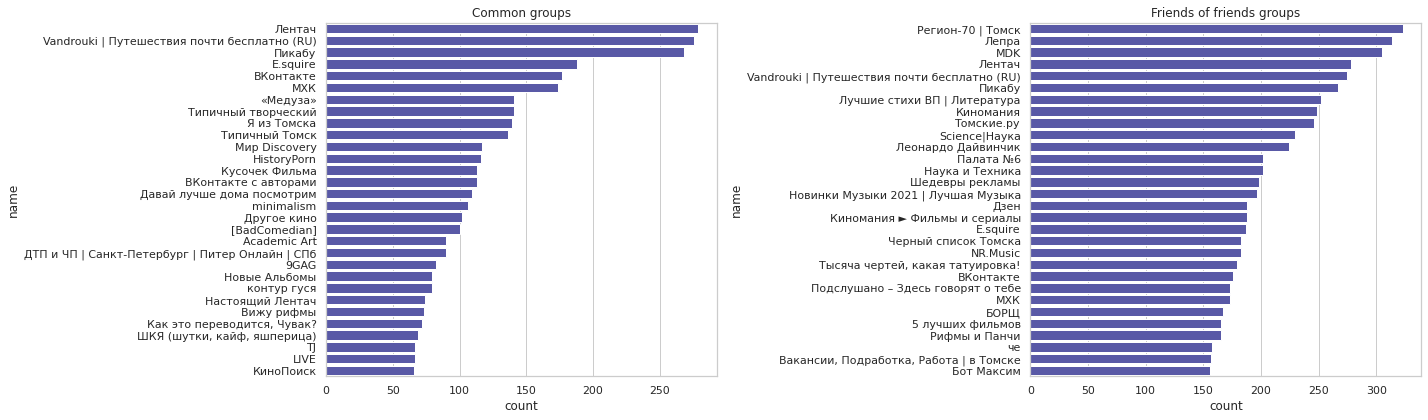

In [130]:
f = plt.figure(figsize=(20, 6))
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
sns.barplot(x=commons_friends_of_friends_groups_freq['count'][:30], y=commons_friends_of_friends_groups_freq['name'][:30], saturation=.3, color='blue')
ax.set_title('Common groups')

ax = f.add_subplot(gs[0, 1])
sns.barplot(x=freinds_of_friends_groups_freq['count'][:30], y=freinds_of_friends_groups_freq['name'][:30], saturation=.3, color='blue')
ax.set_title('Friends of friends groups')
f.tight_layout()

Распределение частоты сообществ немного изменилось.
Выделилась явная тройка лидеров по общим группам - это Лентач, Vandoruki, Пикабу. Но подавляющее число групп друзей друзей не входит в круг интересов пользователя. Явно преобладают люди из города Томск, много развлекательных групп и групп о творчестве (музыка, кино и даже стихи - 7 место)